# 8강 정형데이터 분류 베이스라인 모델 3 피처 중요도

- 세번째 베이스라인 모델에서 LightGBM 외에 XGBoost, CatBoost 모델링을 추가 구현해보고 각 모델의 피처 중요도를 계산하여 그려보기

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering1() : 피처 엔지니어링 함수
- make_lgb_oof_prediction() : LightGBM cross validation out of fold train/predict 함수
- make_xgb_oof_prediction() : XGBoost cross validation out of fold train/predict 함수
- make_cat_oof_prediction() : CatBoost cross validation out of fold train/predict 함수
- plot_feature_importances() : 피처 중요도 플롯 함수

## Library Import

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [3]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

## 평가지표 출력 함수 정의

In [4]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [5]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [6]:
def feature_engineering1(df, year_month):
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [7]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## XGBoost cross validation out of fold train/predict 함수 정의

In [8]:
def make_xgb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # XGBoost 데이터셋 선언
        dtrain = xgb.DMatrix(x_tr, label=y_tr)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        
        # XGBoost 모델 훈련
        clf = xgb.train(
            model_params,
            dtrain,
            num_boost_round=10000, # 트리 개수
            evals=[(dtrain, 'train'), (dvalid, 'valid')],  # Validation 성능을 측정할 수 있도록 설정
            verbose_eval=200,
            early_stopping_rounds=100
        )
        
        # Validation 데이터 예측
        val_preds = clf.predict(dvalid)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(xgb.DMatrix(x_test)) / folds

        # 폴드별 피처 중요도 저장
        fi_tmp = pd.DataFrame.from_records([clf.get_score()]).T.reset_index()
        fi_tmp.columns = ['feature',f'fold_{fold+1}']
        fi = pd.merge(fi, fi_tmp, on='feature')

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## CatBoost cross validation out of fold train/predict 함수 정의

In [9]:
def make_cat_oof_prediction(train, y, test, features, categorical_features=None, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # CatBoost 모델 훈련
        clf = CatBoostClassifier(**model_params)
        clf.fit(x_tr, y_tr,
                eval_set=(x_val, y_val), # Validation 성능을 측정할 수 있도록 설정
                cat_features=categorical_features,
                use_best_model=True,
                verbose=True)
        
        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)[:,1]
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importances_
        
        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## 피처 중요도 플롯 함수 정의

In [10]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [11]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## Pandas info() 함수로 데이터 타입 및 null 체크

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [13]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [14]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-11-30 17:42:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000


## 2011년 11월 Label 데이터 생성

In [15]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

0    4534
1    1188
Name: label, dtype: int64

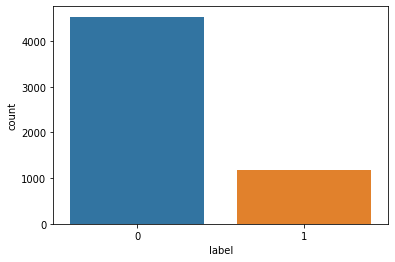

In [16]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언
- early stopping 기능을 사용하기 위해 n_estimators, early_stopping_rounds 설정

In [17]:
lgb_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

## 2011년 12월 LightGBM 베이스라인 모델 예측
- Validation 성능 측정

In [18]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	training's auc: 0.913709	valid_1's auc: 0.762429
Fold 1 | AUC: 0.7624292007551919
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.814389	valid_1's auc: 0.789361
Fold 2 | AUC: 0.7893606781919816
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.859047	valid_1's auc: 0.798187
Fold 3 | AUC: 0.7981874860001494
-------------------------------------------------

# LightGBM 제출 파일 생성

In [19]:
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
submission1 = pd.read_csv('../input/sample_submission.csv')
submission1['probability'] = test_preds
submission1.to_csv(os.path.join(output_dir, 'output_(8)baseline_LightGBM.csv'), index=False)

## 2011년 12월 LightGBM 베이스라인 모델 예측 데이터 분포

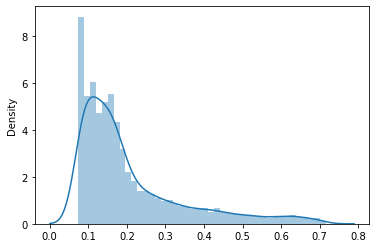

In [20]:
sns.distplot(test_preds)
plt.show()

## LightGBM 피처 중요도 플롯

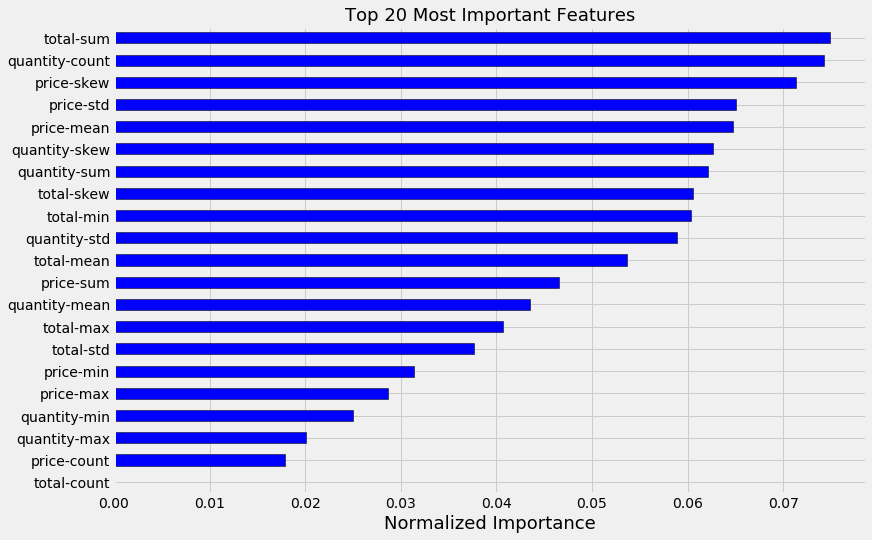

In [21]:
fi = plot_feature_importances(fi)

## XGBoost Hyperparameter 선언

In [22]:
xgb_params = {
    'objective': 'binary:logistic', # 이진 분류
    'learning_rate': 0.1, # 학습률
    'max_depth': 6, # 트리 최고 깊이
    'colsample_bytree': 0.8, # 피처 샘플링 비율
    'subsample': 0.8, # 데이터 샘플링 비율
    'eval_metric': 'auc', # 평가 지표 설정
    'seed': SEED,
} 

## 2011년 12월 XGBoost 베이스라인 모델 예측
- Validation 성능 측정

In [23]:
y_oof, test_preds, fi_xgb = make_xgb_oof_prediction(train, y, test, features, model_params=xgb_params)

fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
[0]	train-auc:0.80378	valid-auc:0.71442
[157]	train-auc:0.99749	valid-auc:0.75292
Fold 1 | AUC: 0.7531373782993374
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
[0]	train-auc:0.79821	valid-auc:0.77514
[101]	train-auc:0.98218	valid-auc:0.77292
Fold 2 | AUC: 0.7733683781882797
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
[0]	train-auc:0.80459	valid-auc:0.73450
[132]	train-auc:0.99313	valid-auc:0.77576
Fold 3 | AUC: 0.7753677294108863
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
[0]	train-auc:0.80069	valid-auc:0.70829
[114]	train-auc:0.98905	valid-auc:0.72736
Fold 4 | AUC: 0.7273575748525348
-------------------------------------------------------------------------

## 2011년 12월 XGBoost 베이스라인 모델 예측 데이터 분포

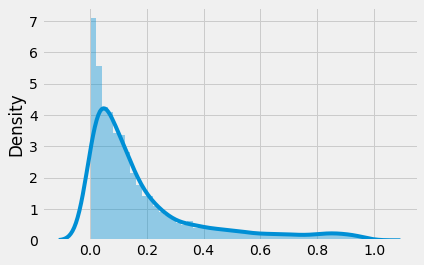

In [24]:
sns.distplot(test_preds)
plt.show()

# XGBoost 제출 파일 생성

In [25]:
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
submission2 = pd.read_csv('../input/sample_submission.csv')
submission2['probability'] = test_preds
submission2.to_csv(os.path.join(output_dir, 'output_(8)baseline_XGBoost.csv'), index=False)

## XGBoost 피처 중요도 플롯

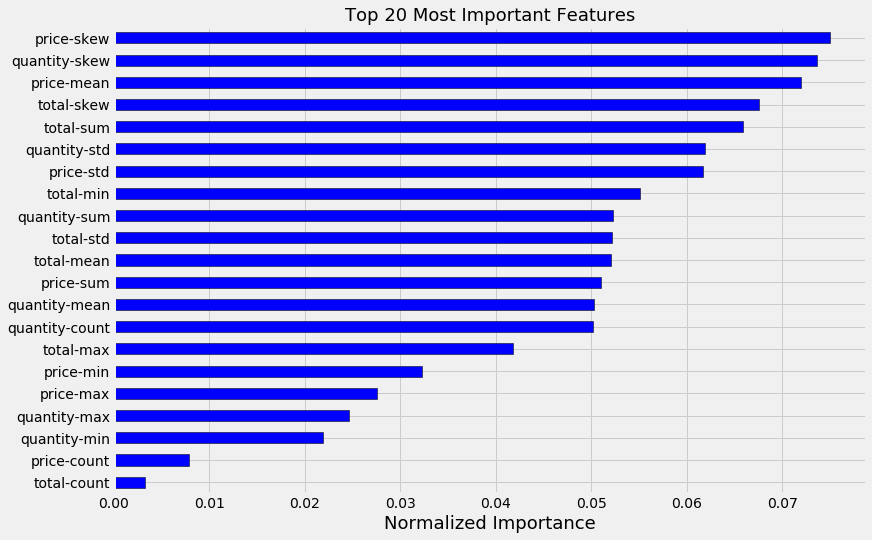

In [26]:
fi_xgb = plot_feature_importances(fi_xgb)

## CatBoost Hyperparameter 선언

In [27]:
cat_params = {
    'n_estimators': 10000, # 트리 개수
    'learning_rate': 0.07, # 학습률
    'eval_metric': 'AUC', # 평가 지표 설정
    'loss_function': 'Logloss', # 손실 함수 설정
    'random_seed': SEED,
    'metric_period': 100,
    'od_wait': 100, # early stopping round
    'depth': 6, # 트리 최고 깊이
    'rsm': 0.8, # 피처 샘플링 비율
}

## 2011년 12월 CatBoost 베이스라인 모델 예측
- Validation 성능 측정

In [28]:
y_oof, test_preds, fi_cat = make_cat_oof_prediction(train, y, test, features, model_params=cat_params)

fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
0:	test: 0.7258357	best: 0.7258357 (0)	total: 61.7ms	remaining: 10m 17s


100:	test: 0.7618184	best: 0.7665754 (39)	total: 494ms	remaining: 48.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7665753526
bestIteration = 39

Shrink model to first 40 iterations.
Fold 1 | AUC: 0.7665753526080036
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
0:	test: 0.7426517	best: 0.7426517 (0)	total: 5.3ms	remaining: 53s


100:	test: 0.7947655	best: 0.7990227 (24)	total: 420ms	remaining: 41.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7990226928
bestIteration = 24

Shrink model to first 25 iterations.
Fold 2 | AUC: 0.7990226927775516
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)


0:	test: 0.7651012	best: 0.7651012 (0)	total: 8.66ms	remaining: 1m 26s
100:	test: 0.7950422	best: 0.8112447 (17)	total: 396ms	remaining: 38.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8112446801
bestIteration = 17

Shrink model to first 18 iterations.
Fold 3 | AUC: 0.8112446800567461
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7183790	best: 0.7183790 (0)	total: 9.05ms	remaining: 1m 30s


100:	test: 0.7541813	best: 0.7623385 (48)	total: 404ms	remaining: 39.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7623385351
bestIteration = 48

Shrink model to first 49 iterations.
Fold 4 | AUC: 0.762338535055626
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7174022	best: 0.7174022 (0)	total: 4.41ms	remaining: 44.1s


100:	test: 0.7857236	best: 0.7857236 (100)	total: 396ms	remaining: 38.8s
200:	test: 0.7956666	best: 0.7967611 (191)	total: 709ms	remaining: 34.6s
300:	test: 0.7948133	best: 0.7969466 (227)	total: 1.02s	remaining: 32.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7969465932
bestIteration = 227

Shrink model to first 228 iterations.
Fold 5 | AUC: 0.796946593206819
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7546979	best: 0.7546979 (0)	total: 3.55ms	remaining: 35.5s


100:	test: 0.7953327	best: 0.7964457 (88)	total: 309ms	remaining: 30.3s
200:	test: 0.7958892	best: 0.7972991 (183)	total: 622ms	remaining: 30.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7972990521
bestIteration = 183

Shrink model to first 184 iterations.
Fold 6 | AUC: 0.7972990520711596
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7804923	best: 0.7804923 (0)	total: 3.69ms	remaining: 37s


100:	test: 0.7867995	best: 0.7943866 (19)	total: 327ms	remaining: 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7943866288
bestIteration = 19

Shrink model to first 20 iterations.
Fold 7 | AUC: 0.7943866288237149
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7402285	best: 0.7402285 (0)	total: 9.57ms	remaining: 1m 35s


100:	test: 0.7775799	best: 0.7776727 (97)	total: 459ms	remaining: 45s
200:	test: 0.7699742	best: 0.7780993 (101)	total: 850ms	remaining: 41.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7780993192
bestIteration = 101

Shrink model to first 102 iterations.
Fold 8 | AUC: 0.7780993191978779
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7357022	best: 0.7357022 (0)	total: 8.57ms	remaining: 1m 25s


100:	test: 0.7795648	best: 0.7810674 (91)	total: 430ms	remaining: 42.2s
200:	test: 0.7844807	best: 0.7878940 (189)	total: 752ms	remaining: 36.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7878939655
bestIteration = 189

Shrink model to first 190 iterations.
Fold 9 | AUC: 0.7878939655332332
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7410355	best: 0.7410355 (0)	total: 10.7ms	remaining: 1m 46s


100:	test: 0.7678409	best: 0.7821990 (6)	total: 423ms	remaining: 41.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7821989723
bestIteration = 6

Shrink model to first 7 iterations.
Fold 10 | AUC: 0.7821989723041534
--------------------------------------------------------------------------------

Mean AUC = 0.7876005791634885
OOF AUC = 0.7658922707444984


# CatBoost 제출 파일 생성

In [29]:
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
submission3 = pd.read_csv('../input/sample_submission.csv')
submission3['probability'] = test_preds
submission3.to_csv(os.path.join(output_dir, 'output_(8)baseline_CatBoost.csv'), index=False)

## 2011년 12월 CatBoost 베이스라인 모델 예측 데이터 분포

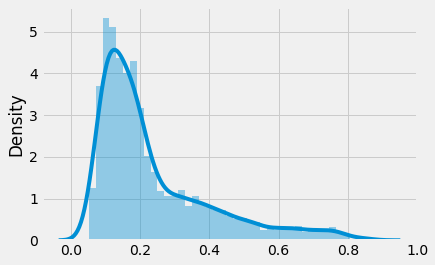

In [30]:
sns.distplot(test_preds)
plt.show()

## CatBoost 피처 중요도 플롯

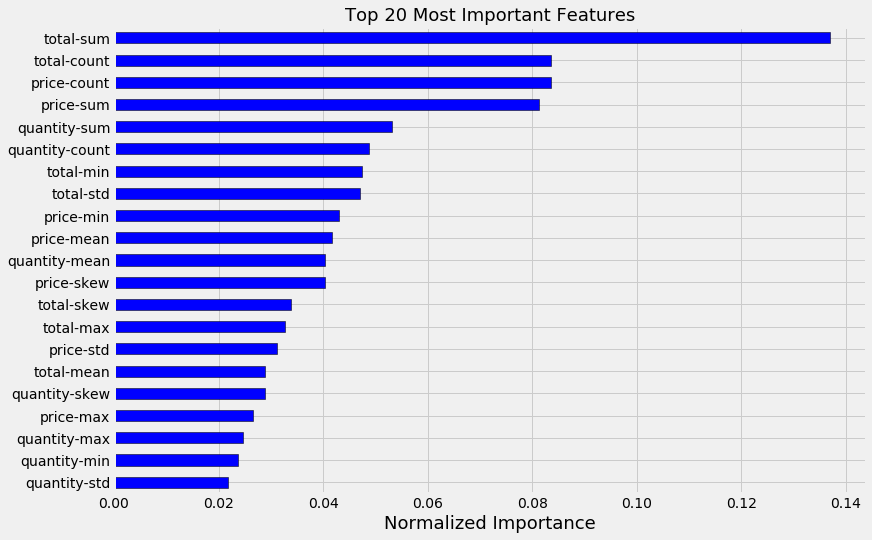

In [31]:
fi_cat = plot_feature_importances(fi_cat)